<a href="https://colab.research.google.com/github/kimhyeongmin-khu/MLMovieProj/blob/main/Lasso_%EC%B5%9C%EC%A2%85_%EB%AA%A8%EB%8D%B8_%ED%8F%89%EA%B0%80(%EB%84%A4%EC%9D%B4%EB%B2%84_%ED%8A%B8%EB%A0%8C%EB%93%9C_%EB%8D%B0%EC%9D%B4%ED%84%B0_%ED%8F%AC%ED%95%A8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Correlation Matrix
                          w1_au   w1_rank  w1_av_sc  w1_av_sales  w1_df_rank  \
w1_au                  1.000000 -0.433667  0.940348     0.572203    0.183080   
w1_rank               -0.433667  1.000000 -0.452207    -0.237265   -0.672653   
w1_av_sc               0.940348 -0.452207  1.000000     0.662287    0.169914   
w1_av_sales            0.572203 -0.237265  0.662287     1.000000    0.141698   
w1_df_rank             0.183080 -0.672653  0.169914     0.141698    1.000000   
w1_slope               0.022293 -0.174834  0.084424     0.091510    0.269232   
di_ca_au_y3            0.453614 -0.138364  0.431790     0.236690    0.067660   
Distributors_mv_au_y3  0.305730 -0.281000  0.246390     0.073291    0.043109   
actor_mv_au_y3         0.395069 -0.382680  0.399512     0.208906    0.167257   
Week1_Avg             -0.083375  0.195415 -0.016197     0.136354   -0.074305   
Over_12                0.100429 -0.220714  0.137713     0.156566    0.131102   
Over_15              

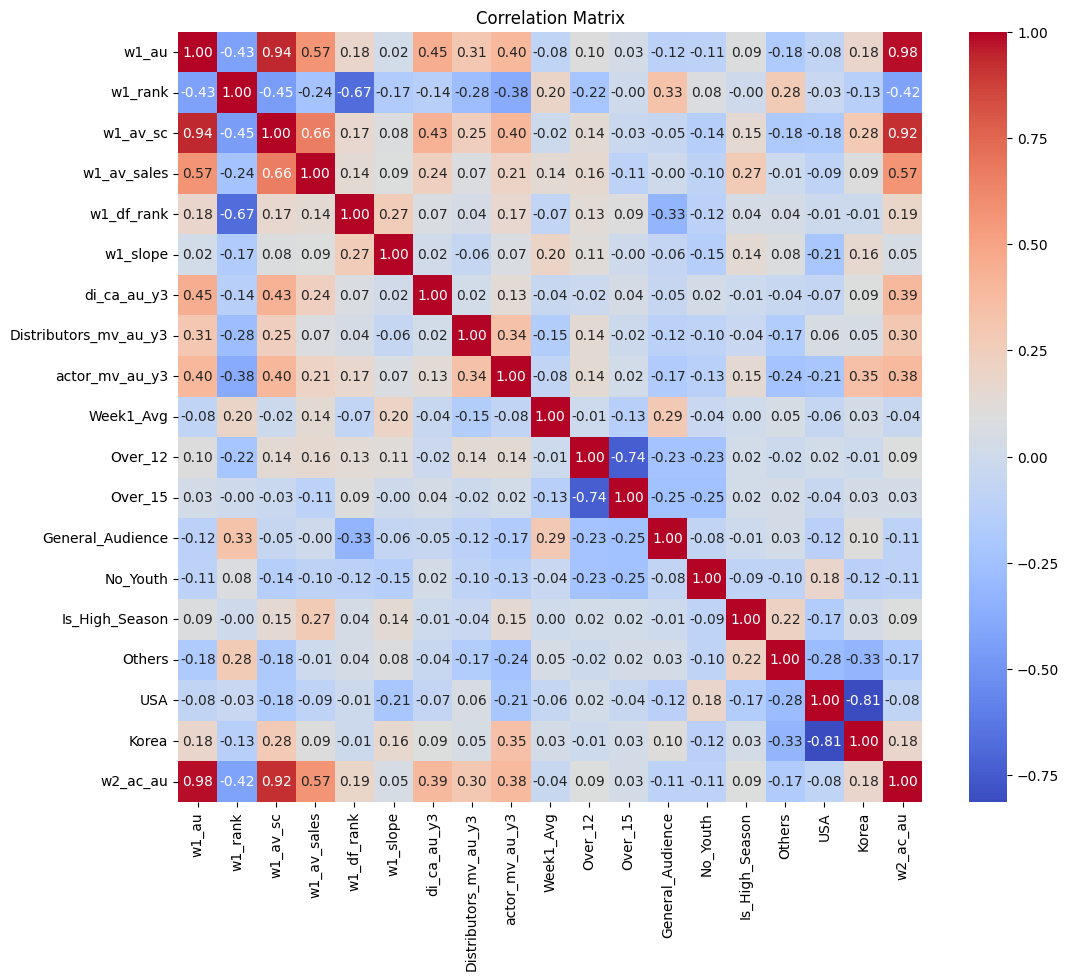

Best alpha for RMSE: 0.0051 with RMSE: 225234.91927637323
Selected features for RMSE: ['w1_au' 'w1_rank' 'w1_av_sc' 'w1_av_sales' 'w1_df_rank' 'w1_slope'
 'Distributors_mv_au_y3' 'Week1_Avg']
Best alpha for MAPE: 0.0045000000000000005 with MAPE: 8.878605450139583
Selected features for MAPE: ['w1_au' 'w1_rank' 'w1_av_sc' 'w1_av_sales' 'w1_df_rank' 'w1_slope'
 'Distributors_mv_au_y3' 'Week1_Avg' 'USA']


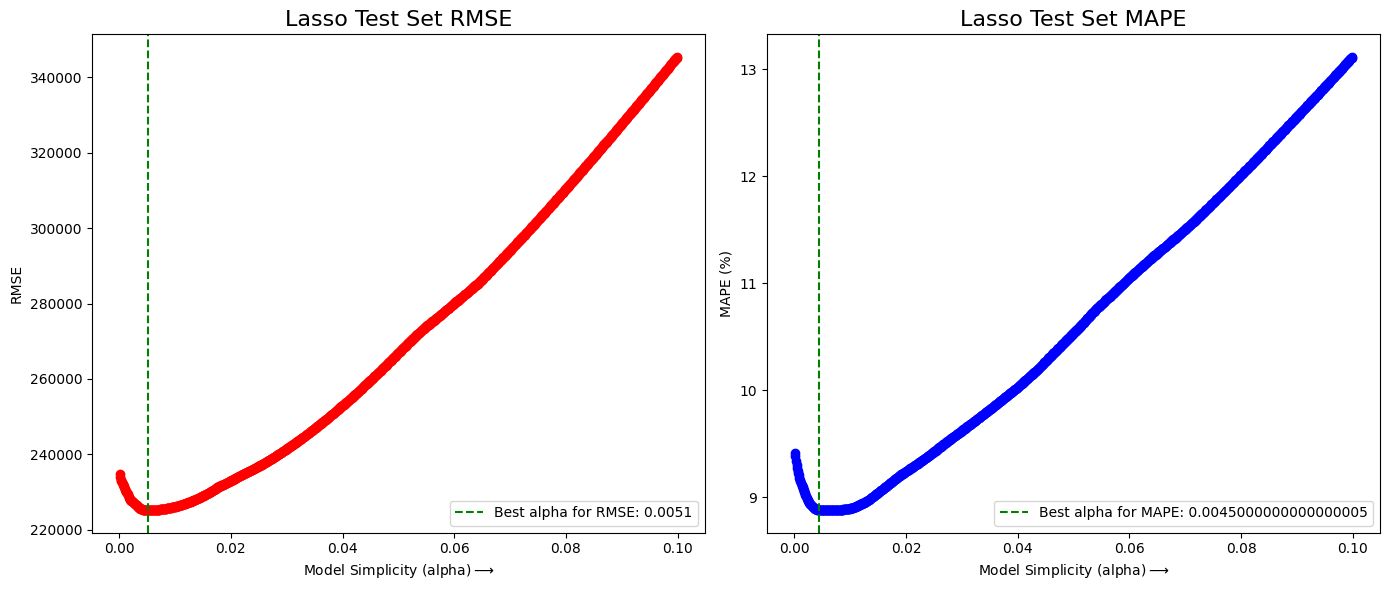

In [ ]:
#w1_slope를 포함한 lasso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# CSV 파일 읽기
file_path = 'preprosessing_ver15.csv'  # 파일 경로를 지정하세요
df = pd.read_csv(file_path)

# 타겟 변수 설정
target_variable = 'w2_ac_au'

# 숫자형 데이터만 선택
numeric_cols = df.select_dtypes(include=[np.number]).columns

# 제외할 열들
exclude_cols = ['w1_slope', 'w1_df_rank', 'w1_mean_diff', 'w2_slope', 'w2_df_rank', 'w2_mean_diff']

# 범주형 열들 (예를 들어 사용자가 지정한 범주형 열들)
categorical_cols = ['Is_High_Season', 'Over_12', 'Over_15', 'General_Audience', 'No_Youth', 'USA', 'Korea', 'Others']

# 제외할 열들을 뺀 나머지 열들
cols_to_transform = [col for col in numeric_cols if col not in exclude_cols]

# 나머지 열들에 대해 0 이하의 값을 작은 양수로 대체
df[cols_to_transform] = df[cols_to_transform].apply(lambda x: np.where(x > 0, x, 1e-6))

user_selected_features = [
   'w1_au', 'w1_rank', 'w1_av_sc', 'w1_av_sales', 'w1_df_rank', 'w1_slope',
   'di_ca_au_y3', 'Distributors_mv_au_y3', 'actor_mv_au_y3', 'Week1_Avg',
   'Over_12', 'Over_15', 'General_Audience', 'No_Youth', 'Is_High_Season',
   'Others', 'USA', 'Korea'
]

# 제공된 기본 피처 세트를 사용
X_transformed = df[user_selected_features].copy()

# 로그 변환 (exclude_cols 제외)
numeric_features_to_log = [col for col in user_selected_features if col not in categorical_cols + exclude_cols]
X_transformed[numeric_features_to_log] = np.log1p(X_transformed[numeric_features_to_log])
y_transformed = np.log1p(df[target_variable])

# 수치형 열만 스케일링
numeric_features = [col for col in user_selected_features if col not in categorical_cols]
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_transformed[numeric_features])

# 스케일링 된 수치형 데이터와 범주형 데이터를 다시 결합
X_combined = np.concatenate([X_numeric_scaled, X_transformed[categorical_cols].values], axis=1)

# 전체 피처 이름 리스트
combined_feature_names = numeric_features + categorical_cols

# 상관 계수 매트릭스 계산
correlation_matrix = df[user_selected_features + [target_variable]].corr()
print("Correlation Matrix")
print(correlation_matrix)
# 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# K-Fold 설정
k_fold = KFold(n_splits=10, shuffle=True, random_state=20)

# Lasso 모델 학습 및 평가
alphas = np.arange(0.0001, 0.1, 0.0001)
lasso_rmse_test = np.zeros(len(alphas))
lasso_mape_test = np.zeros(len(alphas))
lasso_coefs = np.zeros((len(alphas), X_combined.shape[1]))

for train_idx, test_idx in k_fold.split(X_combined):
    X_train, X_test = X_combined[train_idx], X_combined[test_idx]
    y_train, y_test = y_transformed.iloc[train_idx], y_transformed.iloc[test_idx]

    for i, alpha in enumerate(alphas):
        lasso_reg = Lasso(alpha=alpha)
        lasso_reg.fit(X_train, y_train)
        lasso_coefs[i] += lasso_reg.coef_ / k_fold.n_splits

        # 예측
        y_test_pred = lasso_reg.predict(X_test)

        # 예측값을 원래 스케일로 변환
        y_test_pred_original = np.expm1(y_test_pred)
        y_test_original = np.expm1(y_test)

        # RMSE 계산
        lasso_rmse_test[i] += mean_squared_error(y_test_original, y_test_pred_original, squared=False) / k_fold.n_splits

        # MAPE 계산 (퍼센트로 변환)
        lasso_mape_test[i] += mean_absolute_percentage_error(y_test_original, y_test_pred_original) * 100 / k_fold.n_splits

# 최적의 알파 값과 해당하는 MAPE, RMSE 값 찾기
min_rmse_index = np.argmin(lasso_rmse_test)
min_mape_index = np.argmin(lasso_mape_test)

best_alpha_rmse = alphas[min_rmse_index]
best_rmse = lasso_rmse_test[min_rmse_index]

best_alpha_mape = alphas[min_mape_index]
best_mape = lasso_mape_test[min_mape_index]

# 선택된 피처 출력
selected_features_rmse = np.array(combined_feature_names)[lasso_coefs[min_rmse_index] != 0]
selected_features_mape = np.array(combined_feature_names)[lasso_coefs[min_mape_index] != 0]

# 결과 출력
print(f"Best alpha for RMSE: {best_alpha_rmse} with RMSE: {best_rmse}")
print(f"Selected features for RMSE: {selected_features_rmse}")

print(f"Best alpha for MAPE: {best_alpha_mape} with MAPE: {best_mape}")
print(f"Selected features for MAPE: {selected_features_mape}")

# plot RMSE
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(alphas, lasso_rmse_test, 'ro-')
plt.title("Lasso Test Set RMSE", fontsize=16)
plt.xlabel("Model Simplicity (alpha)$\longrightarrow$")
plt.ylabel("RMSE")
plt.axvline(x=best_alpha_rmse, color='g', linestyle='--', label=f'Best alpha for RMSE: {best_alpha_rmse}')
plt.legend()

# plot MAPE
plt.subplot(1, 2, 2)
plt.plot(alphas, lasso_mape_test, 'bo-')
plt.title("Lasso Test Set MAPE", fontsize=16)
plt.xlabel("Model Simplicity (alpha)$\longrightarrow$")
plt.ylabel("MAPE (%)")
plt.axvline(x=best_alpha_mape, color='g', linestyle='--', label=f'Best alpha for MAPE: {best_alpha_mape}')
plt.legend()

plt.tight_layout()
plt.show()


Final RMSE with best alpha for MAPE: 225262.00487234135
Final MAPE with best alpha for MAPE: 8.87860545013958
Final R² with best alpha for MAPE: 0.9635201248224762
                  Feature  Mean Coefficient
0                   w1_au          1.520309
1                 w1_rank         -0.073357
5                w1_slope          0.043979
3             w1_av_sales          0.042571
2                w1_av_sc          0.027021
9               Week1_Avg          0.017822
7   Distributors_mv_au_y3          0.002396
4              w1_df_rank          0.000129
15                    USA         -0.000049
6             di_ca_au_y3          0.000000
8          actor_mv_au_y3          0.000000
10         Is_High_Season          0.000000
11                Over_12          0.000000
12                Over_15          0.000000
13       General_Audience          0.000000
14               No_Youth          0.000000
16                  Korea          0.000000
17                 Others          0.000000


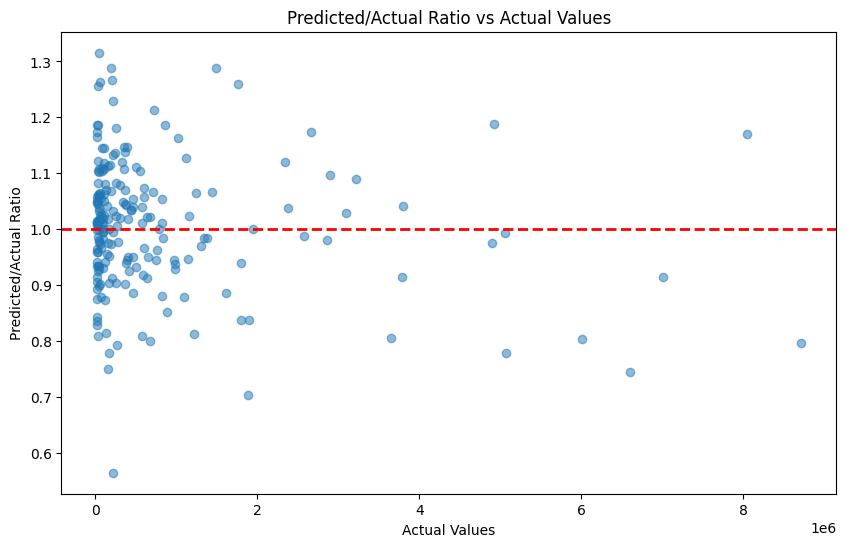

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np
import pandas as pd

# 최적의 알파 값으로 Lasso 회귀 모델 학습 및 평가
best_lasso_reg = Lasso(alpha=best_alpha_mape)

# K-Fold 설정
k_fold = KFold(n_splits=10, shuffle=True, random_state=20)

rmse_scores = []
mape_scores = []
r2_scores = []
coefficients = []
all_actuals = []
all_predictions = []

# feature_names는 X_combined에 사용된 피처들의 이름 리스트입니다.
feature_names = combined_feature_names

for train_idx, test_idx in k_fold.split(X_combined):
    X_train, X_test = X_combined[train_idx], X_combined[test_idx]
    y_train, y_test = y_transformed.iloc[train_idx], y_transformed.iloc[test_idx]

    best_lasso_reg.fit(X_train, y_train)
    y_test_pred = best_lasso_reg.predict(X_test)

    # 예측값을 원래 스케일로 변환
    y_test_pred_original = np.expm1(y_test_pred)
    y_test_original = np.expm1(y_test)

    all_actuals.extend(y_test_original)
    all_predictions.extend(y_test_pred_original)

    # RMSE 계산
    rmse = mean_squared_error(y_test_original, y_test_pred_original, squared=False)
    rmse_scores.append(rmse)

    # MAPE 계산
    mape = mean_absolute_percentage_error(y_test_original, y_test_pred_original) * 100
    mape_scores.append(mape)

    # R^2 계산
    r2 = r2_score(y_test_original, y_test_pred_original)
    r2_scores.append(r2)

    # 계수 저장
    coefficients.append(best_lasso_reg.coef_)

# 최종 결과 출력
final_rmse = np.mean(rmse_scores)
final_mape = np.mean(mape_scores)
final_r2 = np.mean(r2_scores)

# 계수의 평균 계산
coefficients = np.array(coefficients)
mean_coefficients = np.mean(coefficients, axis=0)

# 계수의 이름과 평균을 포함한 데이터프레임 생성
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean Coefficient': mean_coefficients
})

# 절댓값의 크기 순서대로 정렬
coeff_df = coeff_df.reindex(coeff_df['Mean Coefficient'].abs().sort_values(ascending=False).index)

print(f"Final RMSE with best alpha for MAPE: {final_rmse}")
print(f"Final MAPE with best alpha for MAPE: {final_mape}")
print(f"Final R² with best alpha for MAPE: {final_r2}")

# 계수의 평균 출력
print(coeff_df)

# 선택된 피처 출력
selected_features = coeff_df[coeff_df['Mean Coefficient'] != 0]['Feature'].values
print(f"Selected features: {selected_features}")

# 모든 폴드의 실제 값과 예측 값을 데이터프레임으로 저장
all_actuals = np.array(all_actuals)
all_predictions = np.array(all_predictions)

# 오차 비율 계산 및 상위 오차 데이터 저장
error_ratios = np.abs((all_actuals - all_predictions) / all_actuals)
error_data = pd.DataFrame({
    'Actual': all_actuals,
    'Predicted': all_predictions,
    'Error Ratio': error_ratios
})

# 상위 5개와 하위 5개의 오차율 데이터 정렬
top_errors_sorted = error_data.sort_values(by='Error Ratio', ascending=False).head(5)
bottom_errors_sorted = error_data.sort_values(by='Error Ratio', ascending=True).head(5)

print("Top 5 Error Ratios:")
print(top_errors_sorted)
print("\nBottom 5 Error Ratios:")
print(bottom_errors_sorted)

# 예측 값 대비 실제 값의 비율 시각화
plt.figure(figsize=(10, 6))
ratio = all_predictions / all_actuals
plt.scatter(all_actuals, ratio, alpha=0.5)
plt.axhline(y=1, color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted/Actual Ratio')
plt.title('Predicted/Actual Ratio vs Actual Values')
plt.show()


Correlation Matrix
                          w1_au   w1_rank  w1_av_sc  w1_av_sales  w1_df_rank  \
w1_au                  1.000000 -0.433667  0.940348     0.572203    0.183080   
w1_rank               -0.433667  1.000000 -0.452207    -0.237265   -0.672653   
w1_av_sc               0.940348 -0.452207  1.000000     0.662287    0.169914   
w1_av_sales            0.572203 -0.237265  0.662287     1.000000    0.141698   
w1_df_rank             0.183080 -0.672653  0.169914     0.141698    1.000000   
w1_mean_diff           0.093837 -0.190730  0.165740     0.174081    0.277755   
di_ca_au_y3            0.453614 -0.138364  0.431790     0.236690    0.067660   
Distributors_mv_au_y3  0.305730 -0.281000  0.246390     0.073291    0.043109   
actor_mv_au_y3         0.395069 -0.382680  0.399512     0.208906    0.167257   
Week1_Avg             -0.083375  0.195415 -0.016197     0.136354   -0.074305   
Over_12                0.100429 -0.220714  0.137713     0.156566    0.131102   
Over_15              

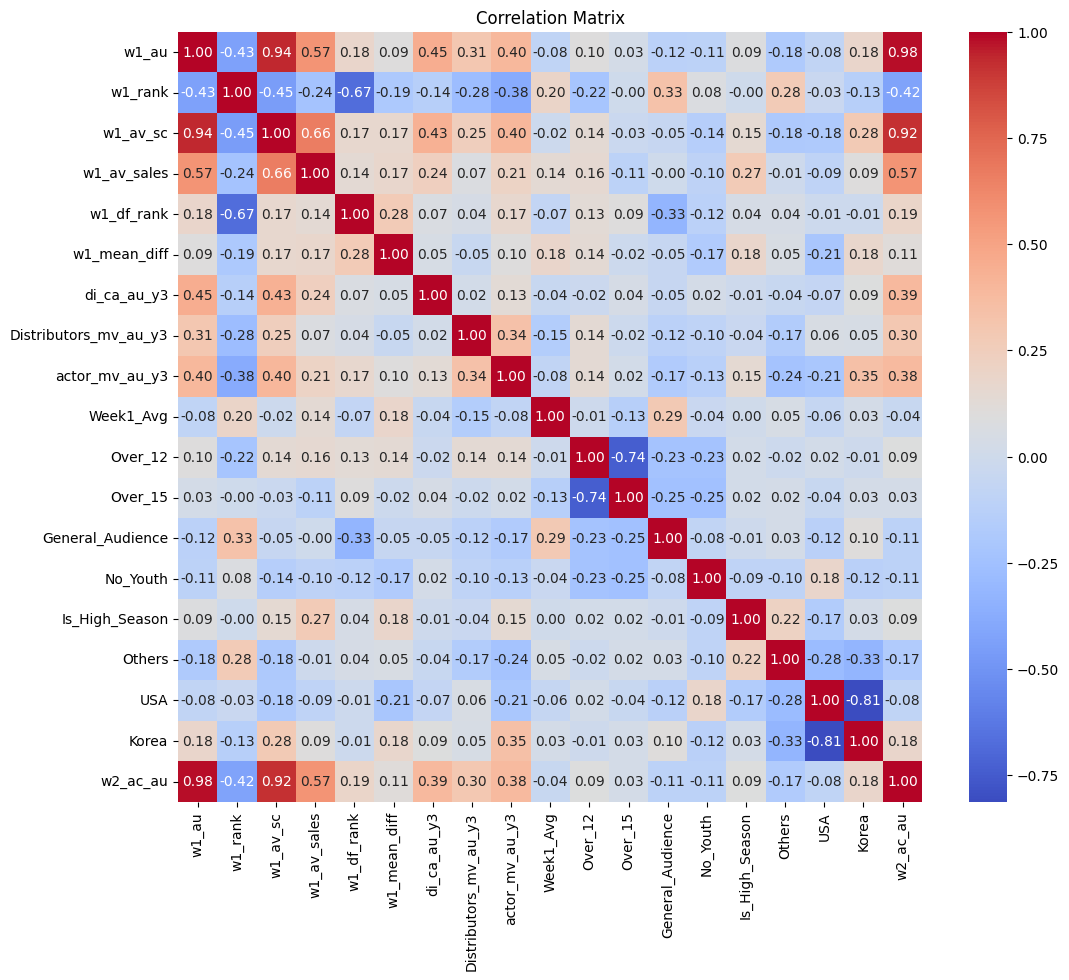

Best alpha for RMSE: 0.0057 with RMSE: 225434.07623807777
Selected features for RMSE: ['w1_au' 'w1_rank' 'w1_av_sc' 'w1_av_sales' 'w1_mean_diff' 'di_ca_au_y3'
 'Distributors_mv_au_y3' 'Week1_Avg']
Best alpha for MAPE: 0.0077 with MAPE: 8.941814770780455
Selected features for MAPE: ['w1_au' 'w1_rank' 'w1_av_sc' 'w1_av_sales' 'w1_mean_diff'
 'Distributors_mv_au_y3' 'Week1_Avg']


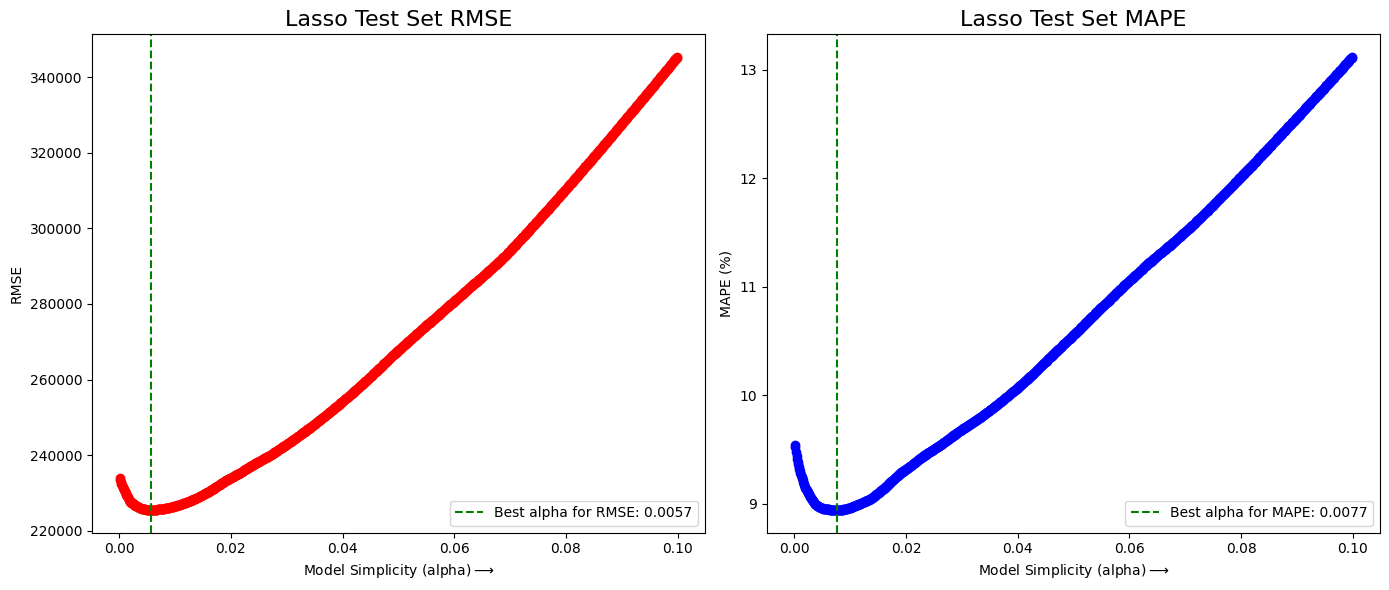

In [ ]:
#w1_mean_diff를 포함한 lasso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# CSV 파일 읽기
file_path = 'preprosessing_ver15.csv'  # 파일 경로를 지정하세요
df = pd.read_csv(file_path)

# 타겟 변수 설정
target_variable = 'w2_ac_au'

# 숫자형 데이터만 선택
numeric_cols = df.select_dtypes(include=[np.number]).columns

# 제외할 열들
exclude_cols = ['w1_slope', 'w1_df_rank', 'w1_mean_diff', 'w2_slope', 'w2_df_rank', 'w2_mean_diff']

# 범주형 열들 (예를 들어 사용자가 지정한 범주형 열들)
categorical_cols = ['Is_High_Season', 'Over_12', 'Over_15', 'General_Audience', 'No_Youth', 'USA', 'Korea', 'Others']

# 제외할 열들을 뺀 나머지 열들
cols_to_transform = [col for col in numeric_cols if col not in exclude_cols]

# 나머지 열들에 대해 0 이하의 값을 작은 양수로 대체
df[cols_to_transform] = df[cols_to_transform].apply(lambda x: np.where(x > 0, x, 1e-6))

user_selected_features = [
   'w1_au', 'w1_rank', 'w1_av_sc', 'w1_av_sales', 'w1_df_rank', 'w1_mean_diff',
   'di_ca_au_y3', 'Distributors_mv_au_y3', 'actor_mv_au_y3', 'Week1_Avg',
   'Over_12', 'Over_15', 'General_Audience', 'No_Youth', 'Is_High_Season',
   'Others', 'USA', 'Korea'
]

# 제공된 기본 피처 세트를 사용
X_transformed = df[user_selected_features].copy()

# 로그 변환 (exclude_cols 제외)
numeric_features_to_log = [col for col in user_selected_features if col not in categorical_cols + exclude_cols]
X_transformed[numeric_features_to_log] = np.log1p(X_transformed[numeric_features_to_log])
y_transformed = np.log1p(df[target_variable])

# 수치형 열만 스케일링
numeric_features = [col for col in user_selected_features if col not in categorical_cols]
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_transformed[numeric_features])

# 스케일링 된 수치형 데이터와 범주형 데이터를 다시 결합
X_combined = np.concatenate([X_numeric_scaled, X_transformed[categorical_cols].values], axis=1)

# 전체 피처 이름 리스트
combined_feature_names = numeric_features + categorical_cols

# 상관 계수 매트릭스 계산
correlation_matrix = df[user_selected_features + [target_variable]].corr()
print("Correlation Matrix")
print(correlation_matrix)
# 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# K-Fold 설정
k_fold = KFold(n_splits=10, shuffle=True, random_state=20)

# Lasso 모델 학습 및 평가
alphas = np.arange(0.0001, 0.1, 0.0001)
lasso_rmse_test = np.zeros(len(alphas))
lasso_mape_test = np.zeros(len(alphas))
lasso_coefs = np.zeros((len(alphas), X_combined.shape[1]))

for train_idx, test_idx in k_fold.split(X_combined):
    X_train, X_test = X_combined[train_idx], X_combined[test_idx]
    y_train, y_test = y_transformed.iloc[train_idx], y_transformed.iloc[test_idx]

    for i, alpha in enumerate(alphas):
        lasso_reg = Lasso(alpha=alpha)
        lasso_reg.fit(X_train, y_train)
        lasso_coefs[i] += lasso_reg.coef_ / k_fold.n_splits

        # 예측
        y_test_pred = lasso_reg.predict(X_test)

        # 예측값을 원래 스케일로 변환
        y_test_pred_original = np.expm1(y_test_pred)
        y_test_original = np.expm1(y_test)

        # RMSE 계산
        lasso_rmse_test[i] += mean_squared_error(y_test_original, y_test_pred_original, squared=False) / k_fold.n_splits

        # MAPE 계산 (퍼센트로 변환)
        lasso_mape_test[i] += mean_absolute_percentage_error(y_test_original, y_test_pred_original) * 100 / k_fold.n_splits

# 최적의 알파 값과 해당하는 MAPE, RMSE 값 찾기
min_rmse_index = np.argmin(lasso_rmse_test)
min_mape_index = np.argmin(lasso_mape_test)

best_alpha_rmse = alphas[min_rmse_index]
best_rmse = lasso_rmse_test[min_rmse_index]

best_alpha_mape = alphas[min_mape_index]
best_mape = lasso_mape_test[min_mape_index]

# 선택된 피처 출력
selected_features_rmse = np.array(combined_feature_names)[lasso_coefs[min_rmse_index] != 0]
selected_features_mape = np.array(combined_feature_names)[lasso_coefs[min_mape_index] != 0]

# 결과 출력
print(f"Best alpha for RMSE: {best_alpha_rmse} with RMSE: {best_rmse}")
print(f"Selected features for RMSE: {selected_features_rmse}")

print(f"Best alpha for MAPE: {best_alpha_mape} with MAPE: {best_mape}")
print(f"Selected features for MAPE: {selected_features_mape}")

# plot RMSE
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(alphas, lasso_rmse_test, 'ro-')
plt.title("Lasso Test Set RMSE", fontsize=16)
plt.xlabel("Model Simplicity (alpha)$\longrightarrow$")
plt.ylabel("RMSE")
plt.axvline(x=best_alpha_rmse, color='g', linestyle='--', label=f'Best alpha for RMSE: {best_alpha_rmse}')
plt.legend()

# plot MAPE
plt.subplot(1, 2, 2)
plt.plot(alphas, lasso_mape_test, 'bo-')
plt.title("Lasso Test Set MAPE", fontsize=16)
plt.xlabel("Model Simplicity (alpha)$\longrightarrow$")
plt.ylabel("MAPE (%)")
plt.axvline(x=best_alpha_mape, color='g', linestyle='--', label=f'Best alpha for MAPE: {best_alpha_mape}')
plt.legend()

plt.tight_layout()
plt.show()


Final RMSE with best alpha for MAPE: 225750.93516156304
Final MAPE with best alpha for MAPE: 8.941814770780454
Final R² with best alpha for MAPE: 0.9625906810626527
                  Feature  Mean Coefficient
0                   w1_au          1.512810
1                 w1_rank         -0.076530
5            w1_mean_diff          0.040105
3             w1_av_sales          0.038661
2                w1_av_sc          0.028546
9               Week1_Avg          0.015549
7   Distributors_mv_au_y3          0.000593
6             di_ca_au_y3          0.000000
8          actor_mv_au_y3          0.000000
4              w1_df_rank          0.000000
10         Is_High_Season          0.000000
11                Over_12          0.000000
12                Over_15          0.000000
13       General_Audience          0.000000
14               No_Youth          0.000000
15                    USA          0.000000
16                  Korea          0.000000
17                 Others          0.000000

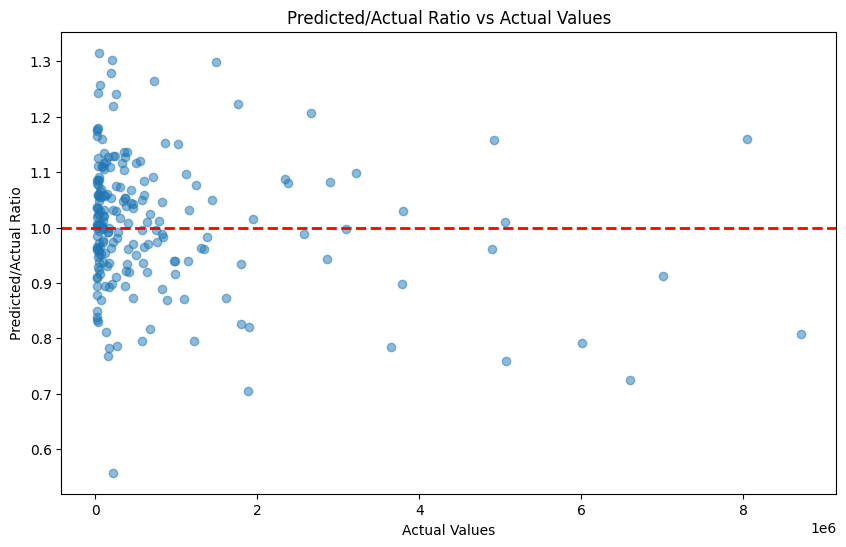

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np
import pandas as pd

# 최적의 알파 값으로 Lasso 회귀 모델 학습 및 평가
best_lasso_reg = Lasso(alpha=best_alpha_mape)

# K-Fold 설정
k_fold = KFold(n_splits=10, shuffle=True, random_state=20)

rmse_scores = []
mape_scores = []
r2_scores = []
coefficients = []
all_actuals = []
all_predictions = []

# feature_names는 X_combined에 사용된 피처들의 이름 리스트입니다.
feature_names = combined_feature_names

for train_idx, test_idx in k_fold.split(X_combined):
    X_train, X_test = X_combined[train_idx], X_combined[test_idx]
    y_train, y_test = y_transformed.iloc[train_idx], y_transformed.iloc[test_idx]

    best_lasso_reg.fit(X_train, y_train)
    y_test_pred = best_lasso_reg.predict(X_test)

    # 예측값을 원래 스케일로 변환
    y_test_pred_original = np.expm1(y_test_pred)
    y_test_original = np.expm1(y_test)

    all_actuals.extend(y_test_original)
    all_predictions.extend(y_test_pred_original)

    # RMSE 계산
    rmse = mean_squared_error(y_test_original, y_test_pred_original, squared=False)
    rmse_scores.append(rmse)

    # MAPE 계산
    mape = mean_absolute_percentage_error(y_test_original, y_test_pred_original) * 100
    mape_scores.append(mape)

    # R^2 계산
    r2 = r2_score(y_test_original, y_test_pred_original)
    r2_scores.append(r2)

    # 계수 저장
    coefficients.append(best_lasso_reg.coef_)

# 최종 결과 출력
final_rmse = np.mean(rmse_scores)
final_mape = np.mean(mape_scores)
final_r2 = np.mean(r2_scores)

# 계수의 평균 계산
coefficients = np.array(coefficients)
mean_coefficients = np.mean(coefficients, axis=0)

# 계수의 이름과 평균을 포함한 데이터프레임 생성
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean Coefficient': mean_coefficients
})

# 절댓값의 크기 순서대로 정렬
coeff_df = coeff_df.reindex(coeff_df['Mean Coefficient'].abs().sort_values(ascending=False).index)

print(f"Final RMSE with best alpha for MAPE: {final_rmse}")
print(f"Final MAPE with best alpha for MAPE: {final_mape}")
print(f"Final R² with best alpha for MAPE: {final_r2}")

# 계수의 평균 출력
print(coeff_df)

# 선택된 피처 출력
selected_features = coeff_df[coeff_df['Mean Coefficient'] != 0]['Feature'].values
print(f"Selected features: {selected_features}")

# 모든 폴드의 실제 값과 예측 값을 데이터프레임으로 저장
all_actuals = np.array(all_actuals)
all_predictions = np.array(all_predictions)

# 오차 비율 계산 및 상위 오차 데이터 저장
error_ratios = np.abs((all_actuals - all_predictions) / all_actuals)
error_data = pd.DataFrame({
    'Actual': all_actuals,
    'Predicted': all_predictions,
    'Error Ratio': error_ratios
})

# 상위 5개와 하위 5개의 오차율 데이터 정렬
top_errors_sorted = error_data.sort_values(by='Error Ratio', ascending=False).head(5)
bottom_errors_sorted = error_data.sort_values(by='Error Ratio', ascending=True).head(5)

print("Top 5 Error Ratios:")
print(top_errors_sorted)
print("\nBottom 5 Error Ratios:")
print(bottom_errors_sorted)

# 예측 값 대비 실제 값의 비율 시각화
plt.figure(figsize=(10, 6))
ratio = all_predictions / all_actuals
plt.scatter(all_actuals, ratio, alpha=0.5)
plt.axhline(y=1, color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted/Actual Ratio')
plt.title('Predicted/Actual Ratio vs Actual Values')
plt.show()


Correlation Matrix
                       w2_ac_au   w2_rank  w2_av_sc  w2_av_sales  w2_df_rank  \
w2_ac_au               1.000000 -0.427385  0.901557     0.495683    0.280585   
w2_rank               -0.427385  1.000000 -0.439597    -0.215273   -0.819225   
w2_av_sc               0.901557 -0.439597  1.000000     0.712977    0.310663   
w2_av_sales            0.495683 -0.215273  0.712977     1.000000    0.193528   
w2_df_rank             0.280585 -0.819225  0.310663     0.193528    1.000000   
w2_slope               0.179240 -0.290032  0.380220     0.358342    0.326426   
di_ca_au_y3            0.385372 -0.137085  0.239659     0.111367    0.087766   
Distributors_mv_au_y3  0.297002 -0.247234  0.195139    -0.019085    0.125041   
actor_mv_au_y3         0.383401 -0.368153  0.321264     0.094571    0.223979   
Week2_Avg             -0.057748  0.161467  0.080725     0.212667   -0.077642   
Over_12                0.092551 -0.244622  0.135756     0.103400    0.184289   
Over_15              

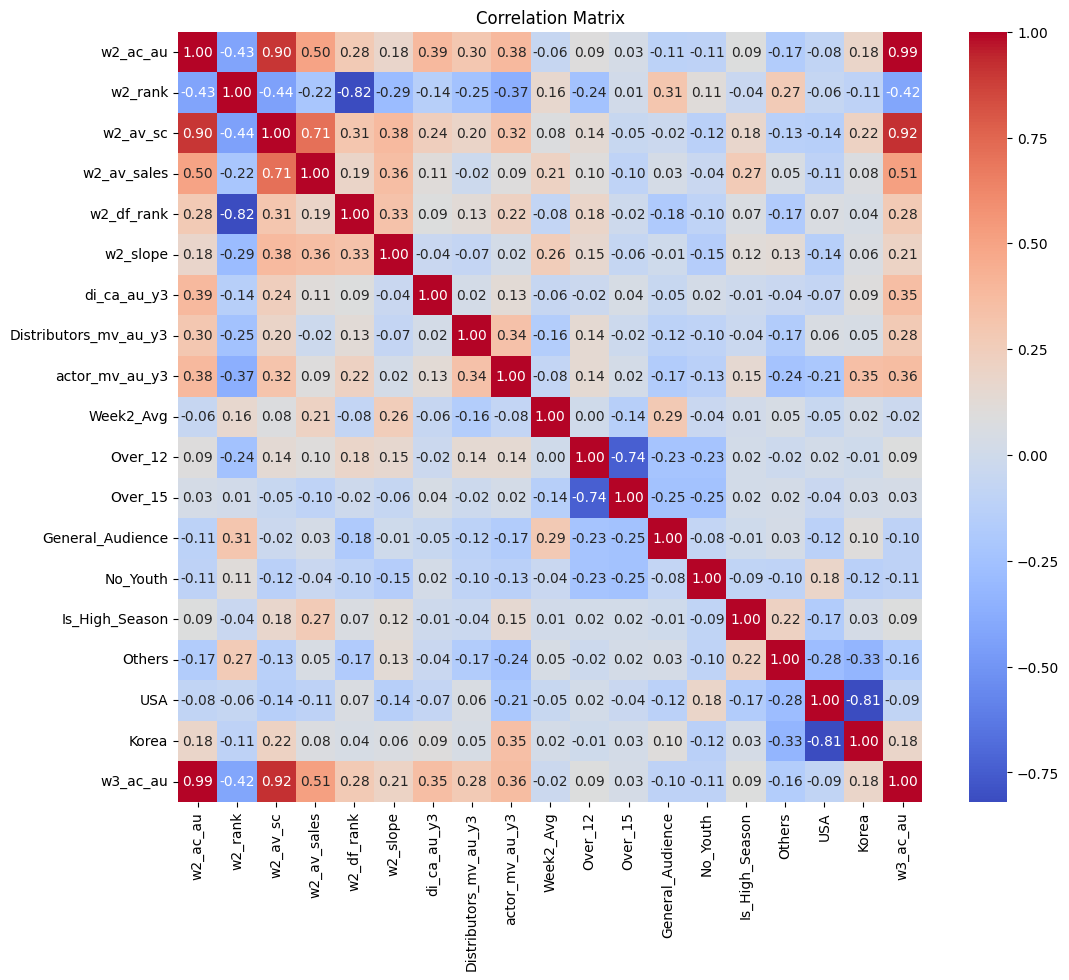

Best alpha for RMSE: 0.0001 with RMSE: 102863.62181227026
Selected features for RMSE: ['w2_ac_au' 'w2_rank' 'w2_av_sc' 'w2_av_sales' 'w2_df_rank' 'w2_slope'
 'di_ca_au_y3' 'Distributors_mv_au_y3' 'actor_mv_au_y3' 'Week2_Avg'
 'Is_High_Season' 'Over_12' 'Over_15' 'General_Audience' 'No_Youth' 'USA'
 'Korea' 'Others']
Best alpha for MAPE: 0.0085 with MAPE: 4.400330867695453
Selected features for MAPE: ['w2_ac_au' 'w2_rank' 'w2_av_sc' 'w2_av_sales' 'w2_df_rank' 'w2_slope'
 'Week2_Avg']


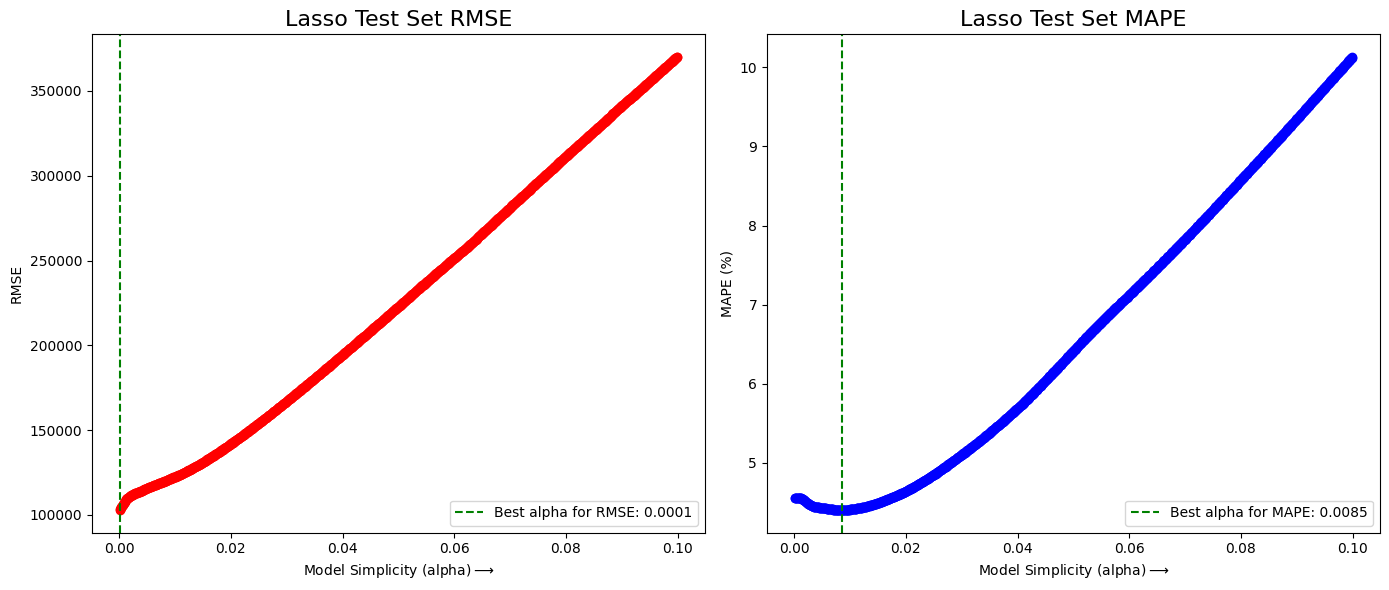

In [ ]:
#w2_slope를 포함한 lasso 분석
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# CSV 파일 읽기
file_path = 'preprosessing_ver15.csv'  # 파일 경로를 지정하세요
df = pd.read_csv(file_path)

# 타겟 변수 설정
target_variable = 'w3_ac_au'

# 숫자형 데이터만 선택
numeric_cols = df.select_dtypes(include=[np.number]).columns

# 제외할 열들
exclude_cols = ['w1_slope', 'w1_df_rank', 'w1_mean_diff', 'w2_slope', 'w2_df_rank', 'w2_mean_diff']

# 범주형 열들 (예를 들어 사용자가 지정한 범주형 열들)
categorical_cols = ['Is_High_Season', 'Over_12', 'Over_15', 'General_Audience', 'No_Youth', 'USA', 'Korea', 'Others']

# 제외할 열들을 뺀 나머지 열들
cols_to_transform = [col for col in numeric_cols if col not in exclude_cols]

# 나머지 열들에 대해 0 이하의 값을 작은 양수로 대체
df[cols_to_transform] = df[cols_to_transform].apply(lambda x: np.where(x > 0, x, 1e-6))

user_selected_features = [
   'w2_ac_au', 'w2_rank', 'w2_av_sc', 'w2_av_sales', 'w2_df_rank', 'w2_slope',
   'di_ca_au_y3', 'Distributors_mv_au_y3', 'actor_mv_au_y3', 'Week2_Avg',
   'Over_12', 'Over_15', 'General_Audience', 'No_Youth', 'Is_High_Season',
   'Others', 'USA', 'Korea'
]

# 제공된 기본 피처 세트를 사용
X_transformed = df[user_selected_features].copy()

# 로그 변환 (exclude_cols 제외)
numeric_features_to_log = [col for col in user_selected_features if col not in categorical_cols + exclude_cols]
X_transformed[numeric_features_to_log] = np.log1p(X_transformed[numeric_features_to_log])
y_transformed = np.log1p(df[target_variable])

# 수치형 열만 스케일링
numeric_features = [col for col in user_selected_features if col not in categorical_cols]
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_transformed[numeric_features])

# 스케일링 된 수치형 데이터와 범주형 데이터를 다시 결합
X_combined = np.concatenate([X_numeric_scaled, X_transformed[categorical_cols].values], axis=1)

# 전체 피처 이름 리스트
combined_feature_names = numeric_features + categorical_cols

# 상관 계수 매트릭스 계산
correlation_matrix = df[user_selected_features + [target_variable]].corr()
print("Correlation Matrix")
print(correlation_matrix)
# 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# K-Fold 설정
k_fold = KFold(n_splits=10, shuffle=True, random_state=20)

# Lasso 모델 학습 및 평가
alphas = np.arange(0.0001, 0.1, 0.0001)
lasso_rmse_test = np.zeros(len(alphas))
lasso_mape_test = np.zeros(len(alphas))
lasso_coefs = np.zeros((len(alphas), X_combined.shape[1]))

for train_idx, test_idx in k_fold.split(X_combined):
    X_train, X_test = X_combined[train_idx], X_combined[test_idx]
    y_train, y_test = y_transformed.iloc[train_idx], y_transformed.iloc[test_idx]

    for i, alpha in enumerate(alphas):
        lasso_reg = Lasso(alpha=alpha)
        lasso_reg.fit(X_train, y_train)
        lasso_coefs[i] += lasso_reg.coef_ / k_fold.n_splits

        # 예측
        y_test_pred = lasso_reg.predict(X_test)

        # 예측값을 원래 스케일로 변환
        y_test_pred_original = np.expm1(y_test_pred)
        y_test_original = np.expm1(y_test)

        # RMSE 계산
        lasso_rmse_test[i] += mean_squared_error(y_test_original, y_test_pred_original, squared=False) / k_fold.n_splits

        # MAPE 계산 (퍼센트로 변환)
        lasso_mape_test[i] += mean_absolute_percentage_error(y_test_original, y_test_pred_original) * 100 / k_fold.n_splits

# 최적의 알파 값과 해당하는 MAPE, RMSE 값 찾기
min_rmse_index = np.argmin(lasso_rmse_test)
min_mape_index = np.argmin(lasso_mape_test)

best_alpha_rmse = alphas[min_rmse_index]
best_rmse = lasso_rmse_test[min_rmse_index]

best_alpha_mape = alphas[min_mape_index]
best_mape = lasso_mape_test[min_mape_index]

# 선택된 피처 출력
selected_features_rmse = np.array(combined_feature_names)[lasso_coefs[min_rmse_index] != 0]
selected_features_mape = np.array(combined_feature_names)[lasso_coefs[min_mape_index] != 0]

# 결과 출력
print(f"Best alpha for RMSE: {best_alpha_rmse} with RMSE: {best_rmse}")
print(f"Selected features for RMSE: {selected_features_rmse}")

print(f"Best alpha for MAPE: {best_alpha_mape} with MAPE: {best_mape}")
print(f"Selected features for MAPE: {selected_features_mape}")

# plot RMSE
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(alphas, lasso_rmse_test, 'ro-')
plt.title("Lasso Test Set RMSE", fontsize=16)
plt.xlabel("Model Simplicity (alpha)$\longrightarrow$")
plt.ylabel("RMSE")
plt.axvline(x=best_alpha_rmse, color='g', linestyle='--', label=f'Best alpha for RMSE: {best_alpha_rmse}')
plt.legend()

# plot MAPE
plt.subplot(1, 2, 2)
plt.plot(alphas, lasso_mape_test, 'bo-')
plt.title("Lasso Test Set MAPE", fontsize=16)
plt.xlabel("Model Simplicity (alpha)$\longrightarrow$")
plt.ylabel("MAPE (%)")
plt.axvline(x=best_alpha_mape, color='g', linestyle='--', label=f'Best alpha for MAPE: {best_alpha_mape}')
plt.legend()

plt.tight_layout()
plt.show()


Final RMSE with best alpha for MAPE: 120362.79588585549
Final MAPE with best alpha for MAPE: 4.400330867695453
Final R² with best alpha for MAPE: 0.992168481071641
                  Feature  Mean Coefficient
0                w2_ac_au          1.563033
2                w2_av_sc          0.054223
5                w2_slope          0.042833
1                 w2_rank         -0.035939
3             w2_av_sales          0.001258
9               Week2_Avg          0.000575
4              w2_df_rank          0.000186
6             di_ca_au_y3          0.000000
7   Distributors_mv_au_y3          0.000000
8          actor_mv_au_y3          0.000000
10         Is_High_Season          0.000000
11                Over_12          0.000000
12                Over_15          0.000000
13       General_Audience          0.000000
14               No_Youth          0.000000
15                    USA          0.000000
16                  Korea          0.000000
17                 Others          0.000000


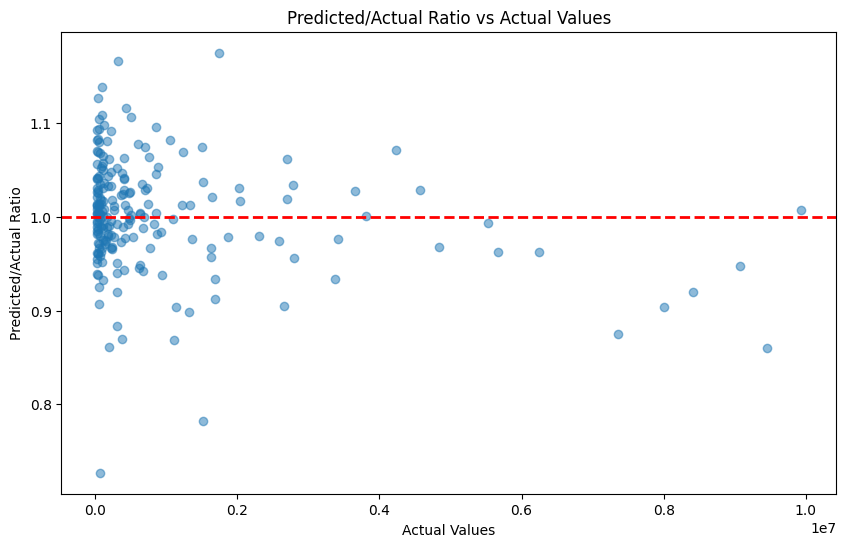

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np
import pandas as pd

# 최적의 알파 값으로 Lasso 회귀 모델 학습 및 평가
best_lasso_reg = Lasso(alpha=best_alpha_mape)

# K-Fold 설정
k_fold = KFold(n_splits=10, shuffle=True, random_state=20)

rmse_scores = []
mape_scores = []
r2_scores = []
coefficients = []
all_actuals = []
all_predictions = []

# feature_names는 X_combined에 사용된 피처들의 이름 리스트입니다.
feature_names = combined_feature_names

for train_idx, test_idx in k_fold.split(X_combined):
    X_train, X_test = X_combined[train_idx], X_combined[test_idx]
    y_train, y_test = y_transformed.iloc[train_idx], y_transformed.iloc[test_idx]

    best_lasso_reg.fit(X_train, y_train)
    y_test_pred = best_lasso_reg.predict(X_test)

    # 예측값을 원래 스케일로 변환
    y_test_pred_original = np.expm1(y_test_pred)
    y_test_original = np.expm1(y_test)

    all_actuals.extend(y_test_original)
    all_predictions.extend(y_test_pred_original)

    # RMSE 계산
    rmse = mean_squared_error(y_test_original, y_test_pred_original, squared=False)
    rmse_scores.append(rmse)

    # MAPE 계산
    mape = mean_absolute_percentage_error(y_test_original, y_test_pred_original) * 100
    mape_scores.append(mape)

    # R^2 계산
    r2 = r2_score(y_test_original, y_test_pred_original)
    r2_scores.append(r2)

    # 계수 저장
    coefficients.append(best_lasso_reg.coef_)

# 최종 결과 출력
final_rmse = np.mean(rmse_scores)
final_mape = np.mean(mape_scores)
final_r2 = np.mean(r2_scores)

# 계수의 평균 계산
coefficients = np.array(coefficients)
mean_coefficients = np.mean(coefficients, axis=0)

# 계수의 이름과 평균을 포함한 데이터프레임 생성
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean Coefficient': mean_coefficients
})

# 절댓값의 크기 순서대로 정렬
coeff_df = coeff_df.reindex(coeff_df['Mean Coefficient'].abs().sort_values(ascending=False).index)

print(f"Final RMSE with best alpha for MAPE: {final_rmse}")
print(f"Final MAPE with best alpha for MAPE: {final_mape}")
print(f"Final R² with best alpha for MAPE: {final_r2}")

# 계수의 평균 출력
print(coeff_df)

# 선택된 피처 출력
selected_features = coeff_df[coeff_df['Mean Coefficient'] != 0]['Feature'].values
print(f"Selected features: {selected_features}")

# 모든 폴드의 실제 값과 예측 값을 데이터프레임으로 저장
all_actuals = np.array(all_actuals)
all_predictions = np.array(all_predictions)

# 오차 비율 계산 및 상위 오차 데이터 저장
error_ratios = np.abs((all_actuals - all_predictions) / all_actuals)
error_data = pd.DataFrame({
    'Actual': all_actuals,
    'Predicted': all_predictions,
    'Error Ratio': error_ratios
})

# 상위 5개와 하위 5개의 오차율 데이터 정렬
top_errors_sorted = error_data.sort_values(by='Error Ratio', ascending=False).head(5)
bottom_errors_sorted = error_data.sort_values(by='Error Ratio', ascending=True).head(5)

print("Top 5 Error Ratios:")
print(top_errors_sorted)
print("\nBottom 5 Error Ratios:")
print(bottom_errors_sorted)

# 예측 값 대비 실제 값의 비율 시각화
plt.figure(figsize=(10, 6))
ratio = all_predictions / all_actuals
plt.scatter(all_actuals, ratio, alpha=0.5)
plt.axhline(y=1, color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted/Actual Ratio')
plt.title('Predicted/Actual Ratio vs Actual Values')
plt.show()


Correlation Matrix
                       w2_ac_au   w2_rank  w2_av_sc  w2_av_sales  w2_df_rank  \
w2_ac_au               1.000000 -0.427385  0.901557     0.495683    0.280585   
w2_rank               -0.427385  1.000000 -0.439597    -0.215273   -0.819225   
w2_av_sc               0.901557 -0.439597  1.000000     0.712977    0.310663   
w2_av_sales            0.495683 -0.215273  0.712977     1.000000    0.193528   
w2_df_rank             0.280585 -0.819225  0.310663     0.193528    1.000000   
w2_mean_diff           0.172105 -0.258591  0.328408     0.315817    0.333934   
di_ca_au_y3            0.385372 -0.137085  0.239659     0.111367    0.087766   
Distributors_mv_au_y3  0.297002 -0.247234  0.195139    -0.019085    0.125041   
actor_mv_au_y3         0.383401 -0.368153  0.321264     0.094571    0.223979   
Week2_Avg             -0.057748  0.161467  0.080725     0.212667   -0.077642   
Over_12                0.092551 -0.244622  0.135756     0.103400    0.184289   
Over_15              

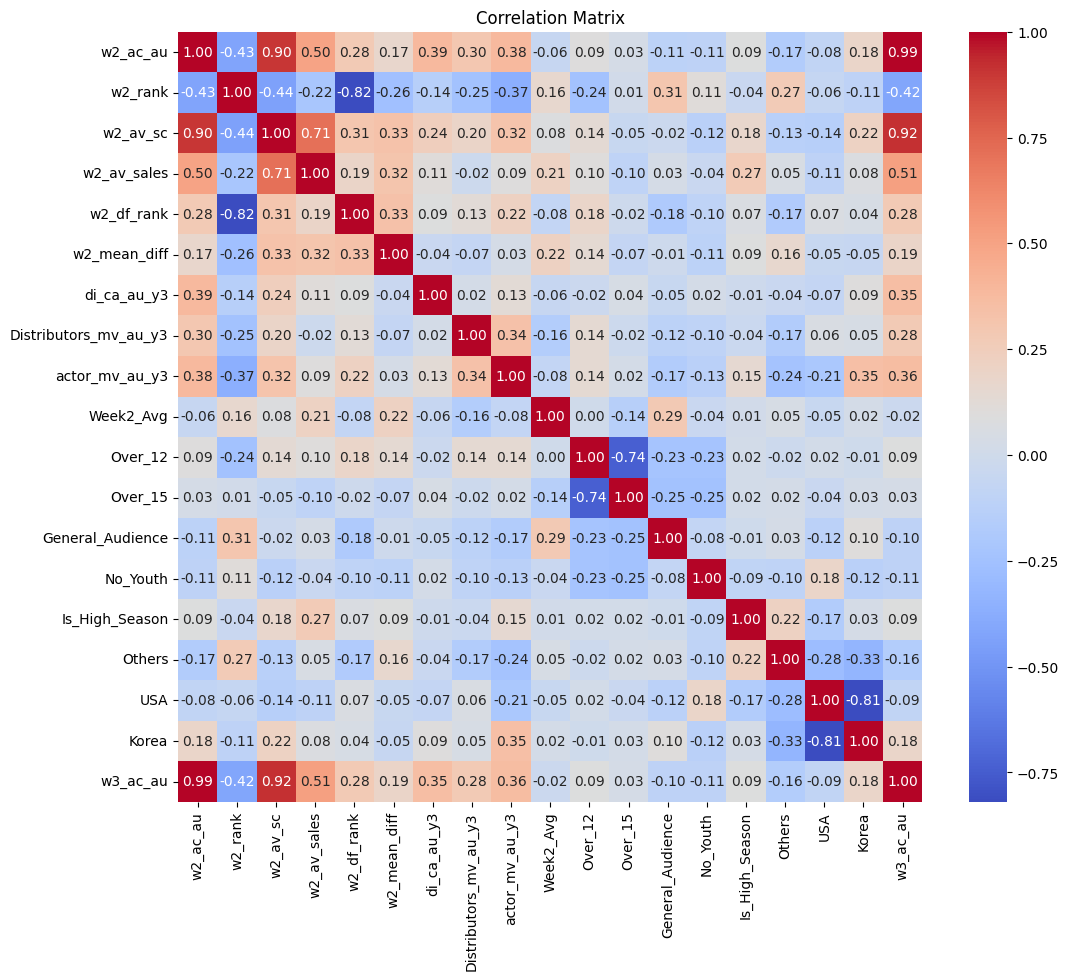

Best alpha for RMSE: 0.0001 with RMSE: 121957.23269628627
Selected features for RMSE: ['w2_ac_au' 'w2_rank' 'w2_av_sc' 'w2_av_sales' 'w2_df_rank' 'w2_mean_diff'
 'di_ca_au_y3' 'Distributors_mv_au_y3' 'actor_mv_au_y3' 'Week2_Avg'
 'Is_High_Season' 'Over_12' 'Over_15' 'General_Audience' 'No_Youth' 'USA'
 'Others']
Best alpha for MAPE: 0.0051 with MAPE: 4.302527049047509
Selected features for MAPE: ['w2_ac_au' 'w2_rank' 'w2_av_sc' 'w2_av_sales' 'w2_mean_diff'
 'Distributors_mv_au_y3' 'actor_mv_au_y3' 'Week2_Avg']


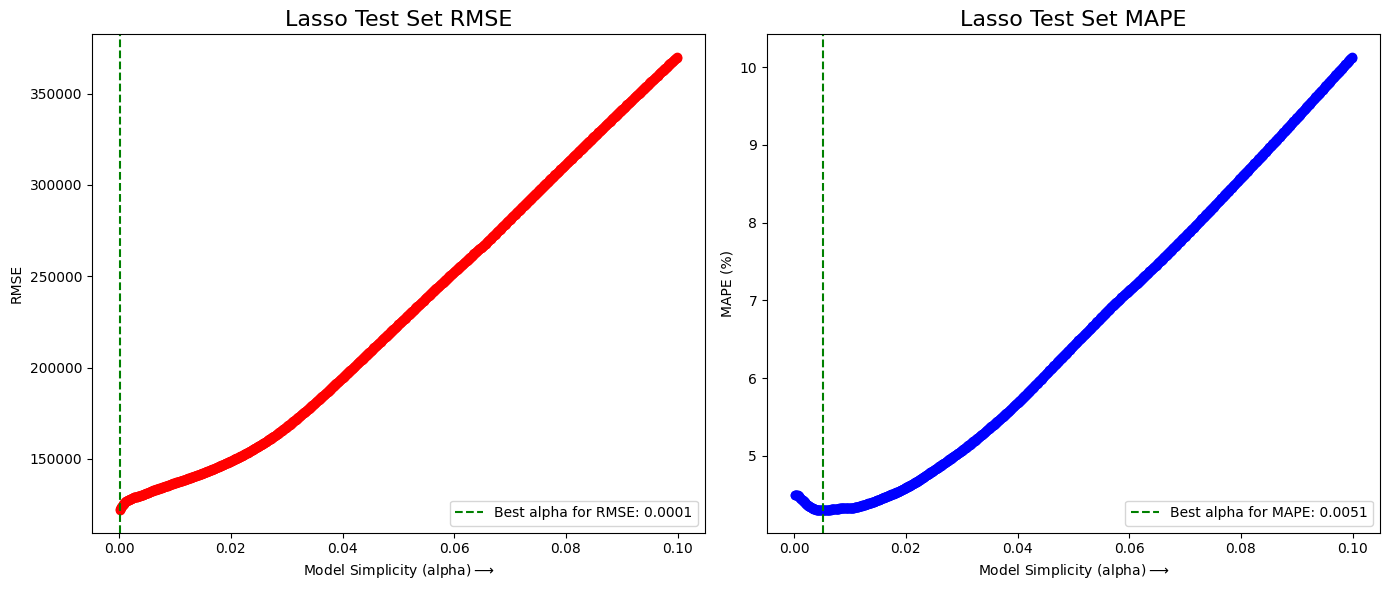

In [ ]:
#w2_mean_diff를 포함한 lasso 분석
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# CSV 파일 읽기
file_path = 'preprosessing_ver15.csv'  # 파일 경로를 지정하세요
df = pd.read_csv(file_path)

# 타겟 변수 설정
target_variable = 'w3_ac_au'

# 숫자형 데이터만 선택
numeric_cols = df.select_dtypes(include=[np.number]).columns

# 제외할 열들
exclude_cols = ['w1_slope', 'w1_df_rank', 'w1_mean_diff', 'w2_slope', 'w2_df_rank', 'w2_mean_diff']

# 범주형 열들 (예를 들어 사용자가 지정한 범주형 열들)
categorical_cols = ['Is_High_Season', 'Over_12', 'Over_15', 'General_Audience', 'No_Youth', 'USA', 'Korea', 'Others']

# 제외할 열들을 뺀 나머지 열들
cols_to_transform = [col for col in numeric_cols if col not in exclude_cols]

# 나머지 열들에 대해 0 이하의 값을 작은 양수로 대체
df[cols_to_transform] = df[cols_to_transform].apply(lambda x: np.where(x > 0, x, 1e-6))

user_selected_features = [
   'w2_ac_au', 'w2_rank', 'w2_av_sc', 'w2_av_sales', 'w2_df_rank', 'w2_mean_diff',
   'di_ca_au_y3', 'Distributors_mv_au_y3', 'actor_mv_au_y3', 'Week2_Avg',
   'Over_12', 'Over_15', 'General_Audience', 'No_Youth', 'Is_High_Season',
   'Others', 'USA', 'Korea'
]

# 제공된 기본 피처 세트를 사용
X_transformed = df[user_selected_features].copy()

# 로그 변환 (exclude_cols 제외)
numeric_features_to_log = [col for col in user_selected_features if col not in categorical_cols + exclude_cols]
X_transformed[numeric_features_to_log] = np.log1p(X_transformed[numeric_features_to_log])
y_transformed = np.log1p(df[target_variable])

# 수치형 열만 스케일링
numeric_features = [col for col in user_selected_features if col not in categorical_cols]
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_transformed[numeric_features])

# 스케일링 된 수치형 데이터와 범주형 데이터를 다시 결합
X_combined = np.concatenate([X_numeric_scaled, X_transformed[categorical_cols].values], axis=1)

# 전체 피처 이름 리스트
combined_feature_names = numeric_features + categorical_cols

# 상관 계수 매트릭스 계산
correlation_matrix = df[user_selected_features + [target_variable]].corr()
print("Correlation Matrix")
print(correlation_matrix)
# 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# K-Fold 설정
k_fold = KFold(n_splits=10, shuffle=True, random_state=20)

# Lasso 모델 학습 및 평가
alphas = np.arange(0.0001, 0.1, 0.0001)
lasso_rmse_test = np.zeros(len(alphas))
lasso_mape_test = np.zeros(len(alphas))
lasso_coefs = np.zeros((len(alphas), X_combined.shape[1]))

for train_idx, test_idx in k_fold.split(X_combined):
    X_train, X_test = X_combined[train_idx], X_combined[test_idx]
    y_train, y_test = y_transformed.iloc[train_idx], y_transformed.iloc[test_idx]

    for i, alpha in enumerate(alphas):
        lasso_reg = Lasso(alpha=alpha)
        lasso_reg.fit(X_train, y_train)
        lasso_coefs[i] += lasso_reg.coef_ / k_fold.n_splits

        # 예측
        y_test_pred = lasso_reg.predict(X_test)

        # 예측값을 원래 스케일로 변환
        y_test_pred_original = np.expm1(y_test_pred)
        y_test_original = np.expm1(y_test)

        # RMSE 계산
        lasso_rmse_test[i] += mean_squared_error(y_test_original, y_test_pred_original, squared=False) / k_fold.n_splits

        # MAPE 계산 (퍼센트로 변환)
        lasso_mape_test[i] += mean_absolute_percentage_error(y_test_original, y_test_pred_original) * 100 / k_fold.n_splits

# 최적의 알파 값과 해당하는 MAPE, RMSE 값 찾기
min_rmse_index = np.argmin(lasso_rmse_test)
min_mape_index = np.argmin(lasso_mape_test)

best_alpha_rmse = alphas[min_rmse_index]
best_rmse = lasso_rmse_test[min_rmse_index]

best_alpha_mape = alphas[min_mape_index]
best_mape = lasso_mape_test[min_mape_index]

# 선택된 피처 출력
selected_features_rmse = np.array(combined_feature_names)[lasso_coefs[min_rmse_index] != 0]
selected_features_mape = np.array(combined_feature_names)[lasso_coefs[min_mape_index] != 0]

# 결과 출력
print(f"Best alpha for RMSE: {best_alpha_rmse} with RMSE: {best_rmse}")
print(f"Selected features for RMSE: {selected_features_rmse}")

print(f"Best alpha for MAPE: {best_alpha_mape} with MAPE: {best_mape}")
print(f"Selected features for MAPE: {selected_features_mape}")

# plot RMSE
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(alphas, lasso_rmse_test, 'ro-')
plt.title("Lasso Test Set RMSE", fontsize=16)
plt.xlabel("Model Simplicity (alpha)$\longrightarrow$")
plt.ylabel("RMSE")
plt.axvline(x=best_alpha_rmse, color='g', linestyle='--', label=f'Best alpha for RMSE: {best_alpha_rmse}')
plt.legend()

# plot MAPE
plt.subplot(1, 2, 2)
plt.plot(alphas, lasso_mape_test, 'bo-')
plt.title("Lasso Test Set MAPE", fontsize=16)
plt.xlabel("Model Simplicity (alpha)$\longrightarrow$")
plt.ylabel("MAPE (%)")
plt.axvline(x=best_alpha_mape, color='g', linestyle='--', label=f'Best alpha for MAPE: {best_alpha_mape}')
plt.legend()

plt.tight_layout()
plt.show()


Final RMSE with best alpha for MAPE: 131417.04895933688
Final MAPE with best alpha for MAPE: 4.302527049047507
Final R² with best alpha for MAPE: 0.9915803786261865
                  Feature  Mean Coefficient
0                w2_ac_au          1.559774
2                w2_av_sc          0.056575
5            w2_mean_diff          0.044625
1                 w2_rank         -0.042661
9               Week2_Avg          0.004149
3             w2_av_sales          0.001977
7   Distributors_mv_au_y3          0.000031
8          actor_mv_au_y3          0.000020
4              w2_df_rank          0.000000
6             di_ca_au_y3          0.000000
10         Is_High_Season          0.000000
11                Over_12          0.000000
12                Over_15          0.000000
13       General_Audience          0.000000
14               No_Youth          0.000000
15                    USA          0.000000
16                  Korea          0.000000
17                 Others          0.000000

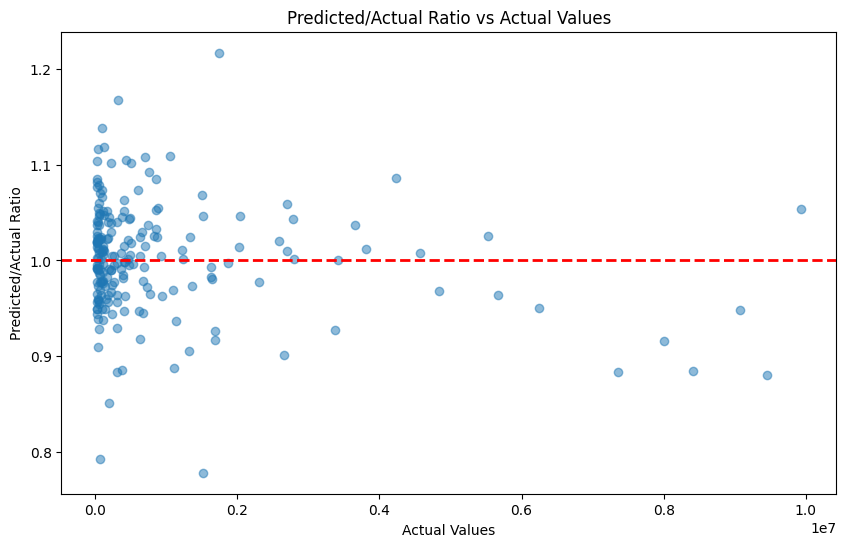

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np
import pandas as pd

# 최적의 알파 값으로 Lasso 회귀 모델 학습 및 평가
best_lasso_reg = Lasso(alpha=best_alpha_mape)

# K-Fold 설정
k_fold = KFold(n_splits=10, shuffle=True, random_state=20)

rmse_scores = []
mape_scores = []
r2_scores = []
coefficients = []
all_actuals = []
all_predictions = []

# feature_names는 X_combined에 사용된 피처들의 이름 리스트입니다.
feature_names = combined_feature_names

for train_idx, test_idx in k_fold.split(X_combined):
    X_train, X_test = X_combined[train_idx], X_combined[test_idx]
    y_train, y_test = y_transformed.iloc[train_idx], y_transformed.iloc[test_idx]

    best_lasso_reg.fit(X_train, y_train)
    y_test_pred = best_lasso_reg.predict(X_test)

    # 예측값을 원래 스케일로 변환
    y_test_pred_original = np.expm1(y_test_pred)
    y_test_original = np.expm1(y_test)

    all_actuals.extend(y_test_original)
    all_predictions.extend(y_test_pred_original)

    # RMSE 계산
    rmse = mean_squared_error(y_test_original, y_test_pred_original, squared=False)
    rmse_scores.append(rmse)

    # MAPE 계산
    mape = mean_absolute_percentage_error(y_test_original, y_test_pred_original) * 100
    mape_scores.append(mape)

    # R^2 계산
    r2 = r2_score(y_test_original, y_test_pred_original)
    r2_scores.append(r2)

    # 계수 저장
    coefficients.append(best_lasso_reg.coef_)

# 최종 결과 출력
final_rmse = np.mean(rmse_scores)
final_mape = np.mean(mape_scores)
final_r2 = np.mean(r2_scores)

# 계수의 평균 계산
coefficients = np.array(coefficients)
mean_coefficients = np.mean(coefficients, axis=0)

# 계수의 이름과 평균을 포함한 데이터프레임 생성
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean Coefficient': mean_coefficients
})

# 절댓값의 크기 순서대로 정렬
coeff_df = coeff_df.reindex(coeff_df['Mean Coefficient'].abs().sort_values(ascending=False).index)

print(f"Final RMSE with best alpha for MAPE: {final_rmse}")
print(f"Final MAPE with best alpha for MAPE: {final_mape}")
print(f"Final R² with best alpha for MAPE: {final_r2}")

# 계수의 평균 출력
print(coeff_df)

# 선택된 피처 출력
selected_features = coeff_df[coeff_df['Mean Coefficient'] != 0]['Feature'].values
print(f"Selected features: {selected_features}")

# 모든 폴드의 실제 값과 예측 값을 데이터프레임으로 저장
all_actuals = np.array(all_actuals)
all_predictions = np.array(all_predictions)

# 오차 비율 계산 및 상위 오차 데이터 저장
error_ratios = np.abs((all_actuals - all_predictions) / all_actuals)
error_data = pd.DataFrame({
    'Actual': all_actuals,
    'Predicted': all_predictions,
    'Error Ratio': error_ratios
})

# 상위 5개와 하위 5개의 오차율 데이터 정렬
top_errors_sorted = error_data.sort_values(by='Error Ratio', ascending=False).head(5)
bottom_errors_sorted = error_data.sort_values(by='Error Ratio', ascending=True).head(5)

print("Top 5 Error Ratios:")
print(top_errors_sorted)
print("\nBottom 5 Error Ratios:")
print(bottom_errors_sorted)

# 예측 값 대비 실제 값의 비율 시각화
plt.figure(figsize=(10, 6))
ratio = all_predictions / all_actuals
plt.scatter(all_actuals, ratio, alpha=0.5)
plt.axhline(y=1, color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted/Actual Ratio')
plt.title('Predicted/Actual Ratio vs Actual Values')
plt.show()


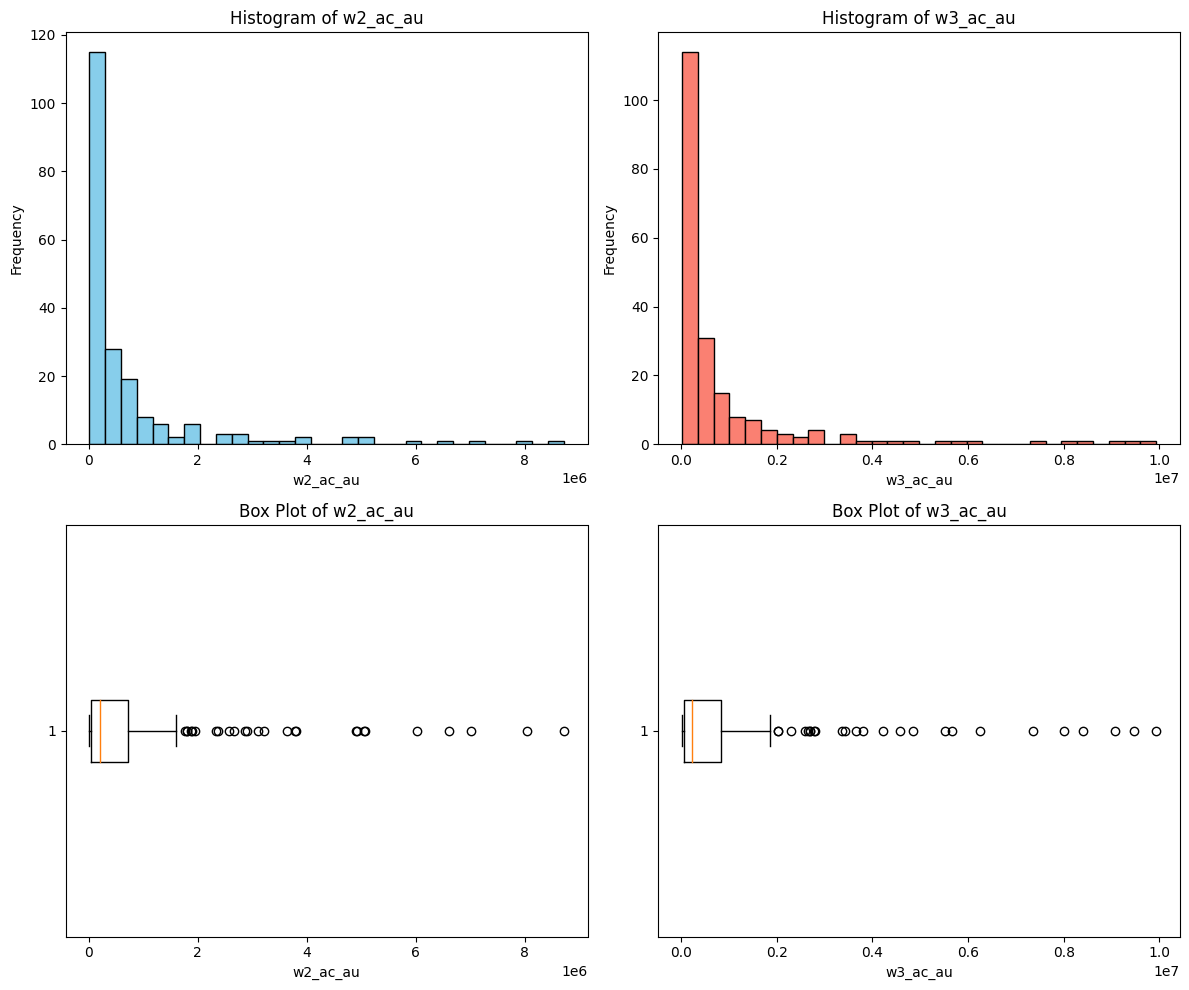

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 읽기
file_path = 'preprosessing_ver15.csv'  # 실제 파일 경로로 변경해주세요.
data = pd.read_csv(file_path)

# w2_ac_au와 w3_ac_au 열의 데이터 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 히스토그램
axes[0, 0].hist(data['w2_ac_au'], bins=30, edgecolor='black', color='skyblue')
axes[0, 0].set_title('Histogram of w2_ac_au')
axes[0, 0].set_xlabel('w2_ac_au')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(data['w3_ac_au'], bins=30, edgecolor='black', color='salmon')
axes[0, 1].set_title('Histogram of w3_ac_au')
axes[0, 1].set_xlabel('w3_ac_au')
axes[0, 1].set_ylabel('Frequency')

# 박스 플롯
axes[1, 0].boxplot(data['w2_ac_au'], vert=False)
axes[1, 0].set_title('Box Plot of w2_ac_au')
axes[1, 0].set_xlabel('w2_ac_au')

axes[1, 1].boxplot(data['w3_ac_au'], vert=False)
axes[1, 1].set_title('Box Plot of w3_ac_au')
axes[1, 1].set_xlabel('w3_ac_au')

plt.tight_layout()
plt.show()
